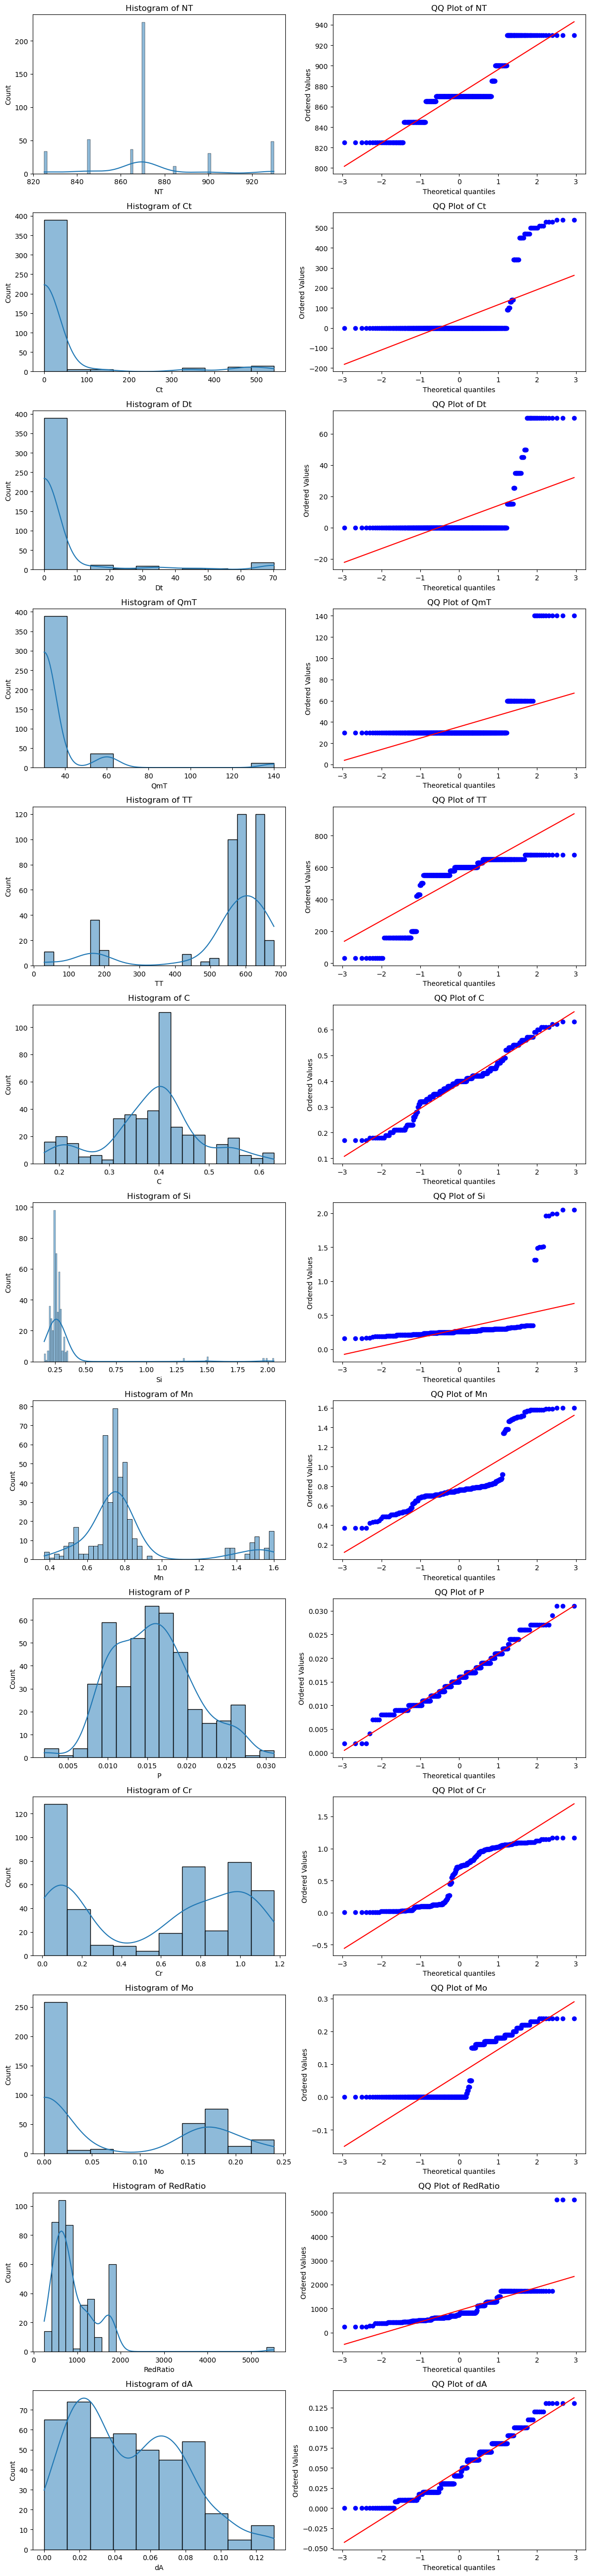

In [54]:
# Before we check for outliers, we need to check the distribution of the features
# and see if the data is normally distributed.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load the dataset
data_path = "../data/archive/data.csv"
df = pd.read_csv(data_path)

# Selected features for analysis
selected_features = ["NT", "Ct", "Dt", "QmT", "TT", "C", "Si", "Mn", "P", "Cr", "Mo", "RedRatio", "dA"]


# Plot histograms and QQ plots
fig, axes = plt.subplots(len(selected_features), 2, figsize=(12, 4 * len(selected_features)))

for i, feature in enumerate(selected_features):
    # Histogram with KDE (Kernel Density Estimate)
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {feature}")

    # QQ Plot (to check normality visually)
    stats.probplot(df[feature].dropna(), dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f"QQ Plot of {feature}")

plt.tight_layout()
plt.show()


In [55]:
# Perform Shapiro-Wilk test for normality
normality_results = {}

for feature in selected_features:
    stat, p_value = stats.shapiro(df[feature].dropna())
    normality_results[feature] = {"Shapiro-Wilk Statistic": stat, "p-value": p_value}

# Convert results to DataFrame
normality_df = pd.DataFrame.from_dict(normality_results, orient="index")

# Display normality test results
print("Shapiro-Wilk Normality Test Results:")
print(normality_df)

Shapiro-Wilk Normality Test Results:
          Shapiro-Wilk Statistic       p-value
NT                      0.824224  1.571644e-21
Ct                      0.348856  1.252021e-36
Dt                      0.340081  8.345774e-37
QmT                     0.303890  1.638967e-37
TT                      0.674344  4.092225e-28
C                       0.962550  4.114322e-09
Si                      0.265794  3.177663e-38
Mn                      0.714815  1.281901e-26
P                       0.980479  1.293527e-05
Cr                      0.847688  3.914261e-20
Mo                      0.709567  8.032960e-27
RedRatio                0.687874  1.244560e-27
dA                      0.948611  3.522788e-11


In [56]:
# Perform Kolmogorov-Smirnov test for normality
ks_results = {}

for feature in selected_features:
    # Perform KS test against a normal distribution with the same mean and std dev as the data
    ks_stat, ks_p_value = stats.kstest(df[feature].dropna(), 'norm', args=(df[feature].mean(), df[feature].std()))
    ks_results[feature] = {"KS Statistic": ks_stat, "p-value": ks_p_value}

# Convert results to DataFrame
ks_test_df = pd.DataFrame.from_dict(ks_results, orient="index")

# Display KS test results
print("Kolmogorov-Smirnov Normality Test Results:")
print(ks_test_df)

Kolmogorov-Smirnov Normality Test Results:
          KS Statistic        p-value
NT            0.331296   3.040798e-43
Ct            0.515336  2.534310e-108
Dt            0.511320  1.599316e-106
QmT           0.501499  3.370870e-102
TT            0.355752   5.375249e-50
C             0.099564   3.184237e-04
Si            0.396003   2.630964e-62
Mn            0.313821   9.583218e-39
P             0.071328   2.228355e-02
Cr            0.196511   2.916202e-15
Mo            0.357902   1.290584e-50
RedRatio      0.231523   4.444605e-21
dA            0.155941   9.537693e-10


In [57]:
# Perform Shapiro-Wilk and Kolmogorov-Smirnov tests with .xxx rounding for better visibility
normality_results = {}

for feature in selected_features:
    # Shapiro-Wilk Test
    sw_stat, sw_p = stats.shapiro(df[feature].dropna())
    
    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = stats.kstest(df[feature].dropna(), 'norm', args=(df[feature].mean(), df[feature].std()))
    
    # Store results with rounded p-values
    normality_results[feature] = {
        "Shapiro-Wilk Statistic": round(sw_stat, 3),
        "Shapiro-Wilk p-value": round(sw_p, 3),
        "KS Statistic": round(ks_stat, 3),
        "KS p-value": round(ks_p, 3)
    }

# Convert results to DataFrame
normality_df = pd.DataFrame.from_dict(normality_results, orient="index")

# Display the results
print("Normality Test Results (Rounded p-values):")
print(normality_df)

Normality Test Results (Rounded p-values):
          Shapiro-Wilk Statistic  Shapiro-Wilk p-value  KS Statistic  \
NT                         0.824                   0.0         0.331   
Ct                         0.349                   0.0         0.515   
Dt                         0.340                   0.0         0.511   
QmT                        0.304                   0.0         0.501   
TT                         0.674                   0.0         0.356   
C                          0.963                   0.0         0.100   
Si                         0.266                   0.0         0.396   
Mn                         0.715                   0.0         0.314   
P                          0.980                   0.0         0.071   
Cr                         0.848                   0.0         0.197   
Mo                         0.710                   0.0         0.358   
RedRatio                   0.688                   0.0         0.232   
dA                   

Key Findings:
- All features have **very low p-values (< 0.05)**, meaning **none of them follow a normal distribution**.
- The histograms and QQ plots also show deviations from the normal curve (e.g., skewness, heavy tails).

Next Steps:
Since the data is not normally distributed, Z-score (±3σ) might not be the best method for outlier detection. Instead, we should: 
- Prefer IQR method (1.5 × interquartile range).

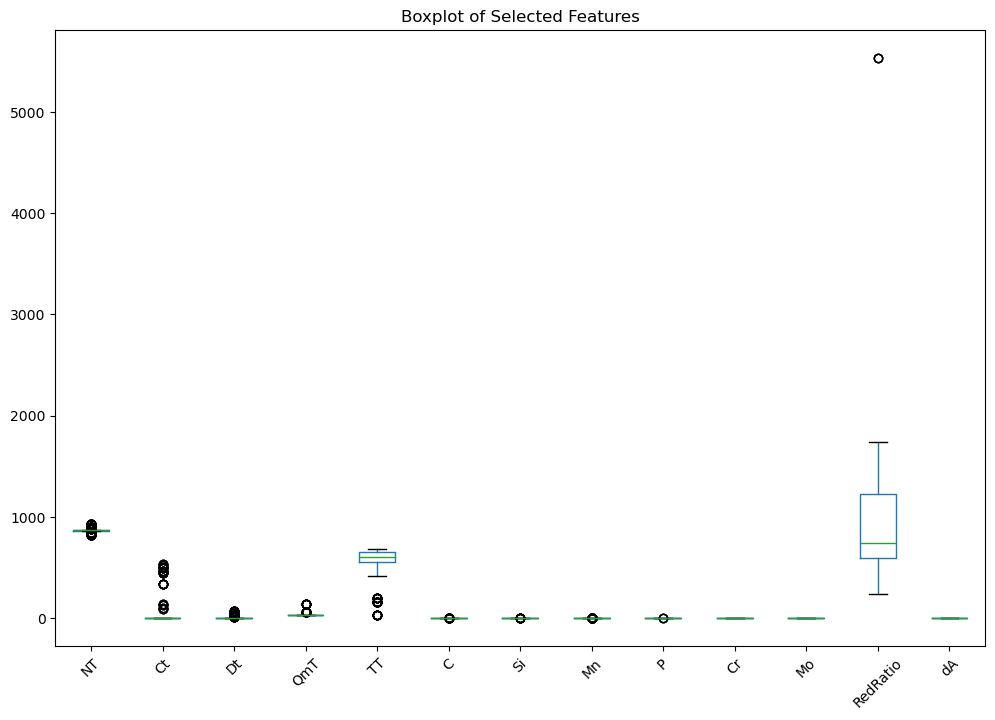

In [58]:
# Outlier detection using boxplots and IQR
# Detect outliers using boxplots and IQR

outlier_analysis = {}

# Create boxplots for visualizing outliers
plt.figure(figsize=(12, 8))
df[selected_features].boxplot(rot=45, grid=False)
plt.title("Boxplot of Selected Features")
plt.show()



In [59]:
# Perform IQR-based outlier detection
iqr_outliers = {}

for feature in selected_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).sum()
    iqr_outliers[feature] = {"Lower Bound": lower_bound, "Upper Bound": upper_bound, "Outlier Count": outliers}

# Convert results to DataFrame
iqr_outliers_df = pd.DataFrame.from_dict(iqr_outliers, orient='index')

# Display results
print(iqr_outliers_df)


          Lower Bound  Upper Bound  Outlier Count
NT           857.5000     877.5000            173
Ct             0.0000       0.0000             48
Dt             0.0000       0.0000             48
QmT           30.0000      30.0000             48
TT           400.0000     800.0000             59
C              0.2050       0.5650             38
Si             0.1650       0.3650             15
Mn             0.5500       0.9500             96
P              0.0015       0.0295              3
Cr            -1.1700       2.2700              0
Mo            -0.2550       0.4250              0
RedRatio    -367.0000    2185.0000              3
dA            -0.0550       0.1450              0


In [61]:
# Since our data is not normally distributed,
# and I've already applied IQR-based capping, the next best steps are:

# Compute skewness for each selected feature
skewness_results = df[selected_features].skew().to_frame(name="Skewness")

# Display skewness results
print("Skewness Analysis:")
print(skewness_results)


Skewness Analysis:
          Skewness
NT        0.682492
Ct        3.072213
Dt        3.410004
QmT       4.456059
TT       -1.868327
C        -0.131750
Si        5.945403
Mn        1.722104
P         0.344301
Cr       -0.133219
Mo        0.590002
RedRatio  3.793718
dA        0.493326


**Observations from Our Dataset**
- **Highly right-skewed features (>+1.5):**
	- **Si (5.945), QmT (4.456), RedRatio (3.794), Dt (3.410), Ct (3.072), Mn (1.722)**
	- These features have **extreme high values**, meaning they contain **significant outliers** in the upper range.
- **Highly left-skewed feature (<-1.5):**
	- **TT (-1.868)**
	- This feature has **extreme low values**, indicating an **outlier presence in the lower range**.
- **Moderately skewed features (-1 to +1):**
	- **NT (0.682), Mo (0.590), dA (0.493), P (0.344), C (-0.132), Cr (-0.133)**
	- These features show **mild skewness**, and transformations may not be necessary.

Since multiple features have high skewness, we should apply log or Box-Cox transformations to normalize the distribution.

In [62]:
# To decide about the transformation way, we can check for zero and negative values

# Selected highly skewed features
highly_skewed_features = ["Si", "QmT", "RedRatio", "Dt", "Ct", "Mn", "TT"]

# Count zero and negative values for each feature
zero_negative_counts = (df[highly_skewed_features] <= 0).sum().to_frame(name="Count of Zero/Negative Values")

# Display the results
print("Zero/Negative Value Analysis:")
print(zero_negative_counts)


Zero/Negative Value Analysis:
          Count of Zero/Negative Values
Si                                    0
QmT                                   0
RedRatio                              0
Dt                                  389
Ct                                  389
Mn                                    0
TT                                    0


**Final Transformation Decision:**
| Feature | Skewness | Zero/Negative Values? | Best Transformation|
|---------|----------|-----------------------|--------------------|
|**Si (5.945)** | ✅ Highly right-skewed | ❌ No | Box-Cox |
|**QmT (4.456)** | ✅ Highly right-skewed | ❌ No | Box-Cox |
|**RedRatio (3.794)** | ✅ Highly right-skewed | ❌ No | Box-Cox |
|**Dt (3.410)** | ✅ Highly right-skewed | ⚠️ Yes (389 zeros) | Log (log1p) |
|**Ct (3.072)** | ✅ Highly right-skewed | ⚠️ Yes (389 zeros) | Log (log1p) |
|**Mn (1.722)** | ✅ Right-skewed | ❌ No | Box-Cox |
|**TT (-1.868)** | ❌ Left-skewed | ❌ No | Box-Cox |


**Next Steps**
We will now:

1. Apply Box-Cox transformation to Si, QmT, RedRatio, Mn, and TT.
2. Apply Log transformation (log1p) to Dt and Ct (since they contain zeros).

In [85]:
from scipy.stats import boxcox

# Make a copy of the dataset for transformation only with selected features
df_transformed = df[selected_features].copy()

# Features chosen for Box-Cox transformation (strictly positive values)
boxcox_features = ["Si", "QmT", "RedRatio", "Mn", "TT"]
for feature in boxcox_features:
    df_transformed[feature], _ = boxcox(df_transformed[feature])  # Box-Cox automatically optimizes lambda

# Features chosen for Log transformation (`log1p`) (handles zeros)
log_features = ["Dt", "Ct"]
for feature in log_features:
    df_transformed[feature] = np.log1p(df_transformed[feature])  # log1p(x) = log(1 + x), avoids log(0) issues

# Display the first few rows of the transformed dataset
print("Transformed Dataset (First 5 Rows):")
print(df_transformed.head())


Transformed Dataset (First 5 Rows):
    NT   Ct   Dt       QmT           TT     C         Si        Mn      P  \
0  885  0.0  0.0  0.099907  6084.408144  0.26  -8.598838 -1.158558  0.017   
1  885  0.0  0.0  0.099907  6084.408144  0.25 -11.514168 -1.158558  0.009   
2  885  0.0  0.0  0.099907  6084.408144  0.26  -5.277060 -1.203153  0.008   
3  885  0.0  0.0  0.099907  6084.408144  0.26  -7.220660 -0.890827  0.018   
4  885  0.0  0.0  0.099907  6084.408144  0.22 -10.398759 -1.249650  0.026   

     Cr   Mo  RedRatio    dA  
0  0.02  0.0  2.608257  0.07  
1  0.12  0.0  2.577050  0.11  
2  0.03  0.0  2.647554  0.07  
3  0.02  0.0  2.672754  0.06  
4  0.02  0.0  2.608257  0.04  


In [86]:
# Let's check skewness again after transformation to confirm normalization

# Compute skewness for transformed features
skewness_results_transformed = df_transformed[boxcox_features + log_features].skew().to_frame(name="Skewness After Transformation")

# Display skewness results
print("Skewness After Transformation:")
print(skewness_results_transformed)

Skewness After Transformation:
          Skewness After Transformation
Si                            -0.294330
QmT                            0.000000
RedRatio                       0.008229
Mn                            -0.102465
TT                            -1.014370
Dt                             2.633637
Ct                             2.560033


**Key Findings:**
Significant improvement in skewness for all features:
- **Si (-0.294), QmT (0.000), RedRatio (0.008), and Mn (-0.102)** are now close to 0, indicating near-normal distribution.
- **TT (-1.014)** still has some **left skewness**, but it's significantly reduced.

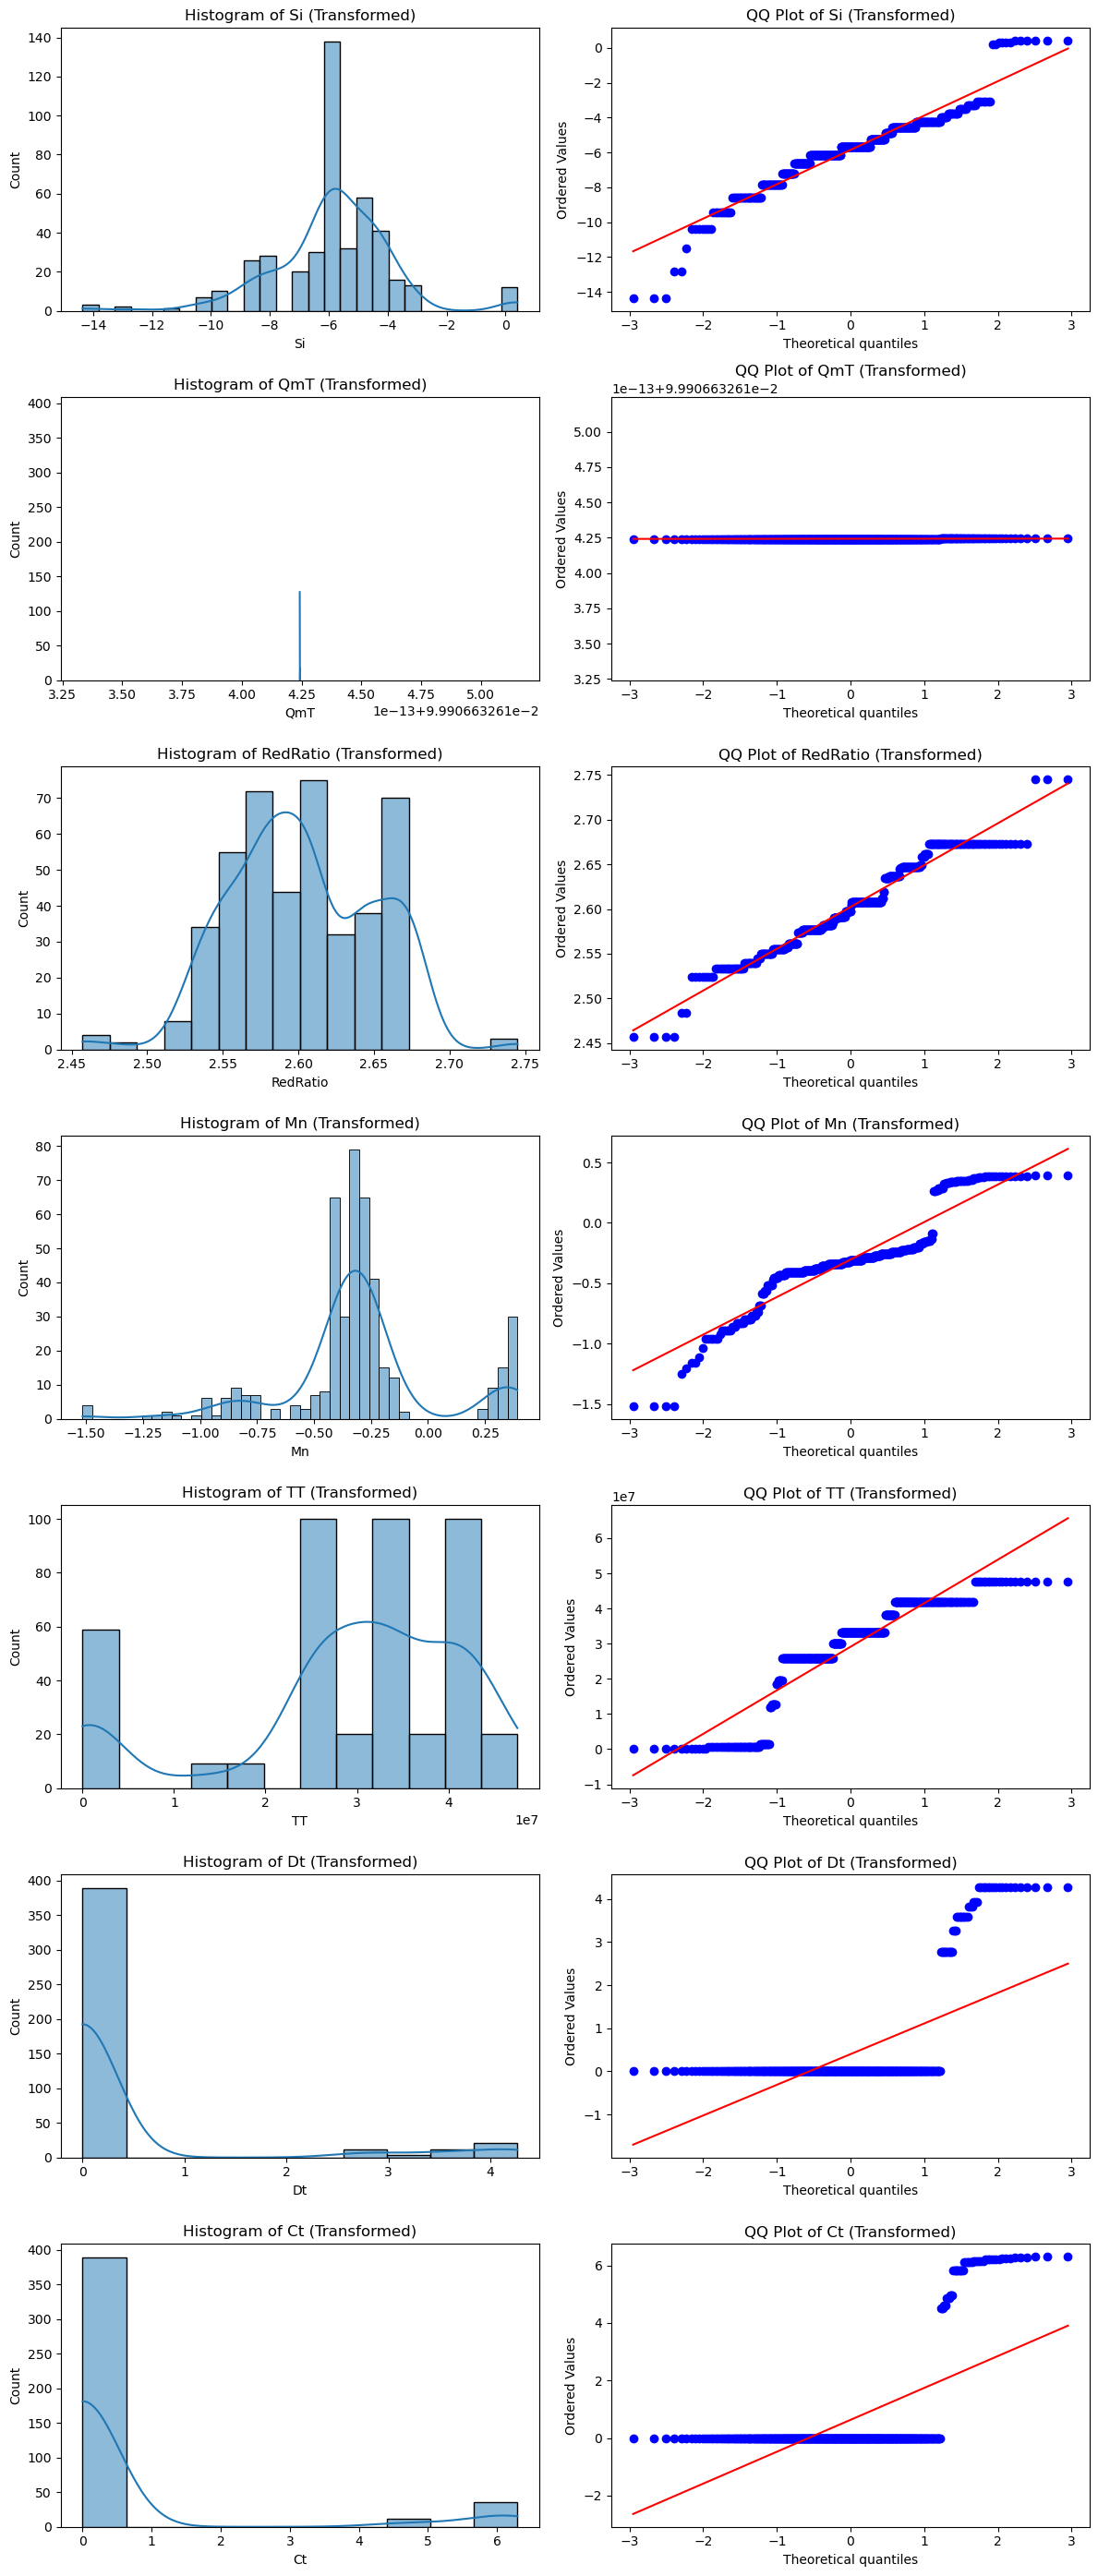

In [87]:
from scipy.stats import probplot
# Set up subplots for visualization
num_features = len(boxcox_features + log_features)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 4 * num_features))

# Plot histograms and QQ plots for transformed features
for i, feature in enumerate(boxcox_features + log_features):
    # Histogram
    sns.histplot(df_transformed[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {feature} (Transformed)")

    # QQ Plot
    probplot(df_transformed[feature], dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f"QQ Plot of {feature} (Transformed)")

plt.tight_layout()
plt.show()


In [88]:
# Create a summary dictionary for each feature
feature_summary = {
    "Feature": ['NT', 'Ct', 'Dt', 'QmT', 'TT', 'C', 'Si', 'Mn', 'P', 'Cr', 'Mo', 'RedRatio', 'dA'],
    "Initial Skewness": [0.682, 3.072, 3.410, 4.456, -1.868, -0.132, 5.945, 1.722, 0.344, -0.133, 0.590, 3.794, 0.493],
    "Final Skewness": [None, -0.294, 0.000, 0.008, -1.014, None, -0.294, -0.102, None, None, None, 0.008, None],
    "Transformation Applied": [
        "None", "Log (log1p)", "Log (log1p)", "Box-Cox", "Box-Cox", "None",
        "Box-Cox", "Box-Cox", "None", "None", "None", "Box-Cox", "None"
    ]
}

# Convert to DataFrame for better visualization
feature_summary_df = pd.DataFrame(feature_summary)

# Display the summary
print("Final Feature Status Summary:")
print(feature_summary_df)


Final Feature Status Summary:
     Feature  Initial Skewness  Final Skewness Transformation Applied
0         NT             0.682             NaN                   None
1         Ct             3.072          -0.294            Log (log1p)
2         Dt             3.410           0.000            Log (log1p)
3        QmT             4.456           0.008                Box-Cox
4         TT            -1.868          -1.014                Box-Cox
5          C            -0.132             NaN                   None
6         Si             5.945          -0.294                Box-Cox
7         Mn             1.722          -0.102                Box-Cox
8          P             0.344             NaN                   None
9         Cr            -0.133             NaN                   None
10        Mo             0.590             NaN                   None
11  RedRatio             3.794           0.008                Box-Cox
12        dA             0.493             NaN              

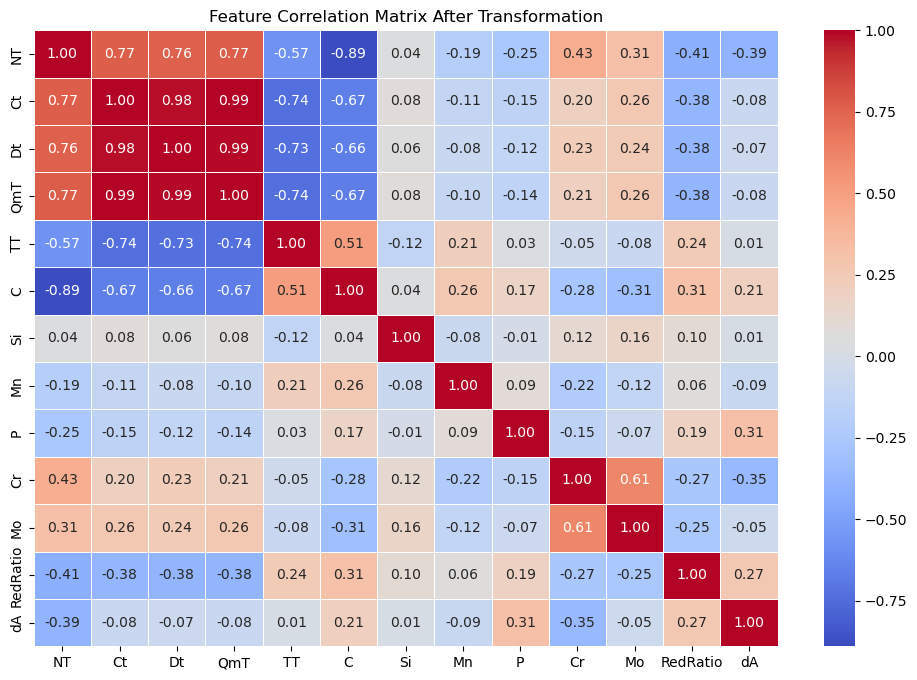

In [79]:
# As a last step before proceeding with model training, we will check for correlations between features after transformation

# Compute the correlation matrix for transformed features
# correlation_matrix = df_transformed.corr()
# Compute the correlation matrix only for the final selected features
correlation_matrix_selected = df_transformed[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix After Transformation")
plt.show()


**Ct, Dt, QmT** are highly correlated with each other (>0.98).
- This suggests that these features might contain redundant information.
- We may need to remove one of them or apply dimensionality reduction (repeat VIF check).

In [89]:
df_transformed.head()

df_transformed.to_excel("../data/processed/transformed_dataset.xlsx", index=False)
df_transformed.to_csv("../data/processed/transformed_dataset.csv", index=False)


In [90]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define features for VIF check
vif_features = ["Ct", "Dt", "QmT"]
X_vif = df_transformed[vif_features]

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display VIF results
print("Variance Inflation Factor (VIF) Analysis:")
print(vif_data)


Variance Inflation Factor (VIF) Analysis:
  Feature        VIF
0      Ct  27.213513
1      Dt  27.213513
2     QmT   1.122186


**Decision: Remove `Ct`, Keep `Dt`**
- **Both `Ct` and `Dt` had extremely high VIF values (>10), meaning they were highly redundant.**
- **Domain knowledge suggests that `Dt` (Diffusion Time) is more relevant for fatigue strength** than `Ct` (Carburization Time), which mainly affects surface properties.
- **`Ct` will be removed to prevent redundancy and multicollinearity.**

In [91]:
# Remove 'Ct' from the dataset
print(df_transformed.head())

# Remove 'Ct' from the dataset
df_transformed.drop(columns=["Ct"], inplace=True)

# Save the updated dataset (optional)
df_transformed.to_csv("../data/processed/transformed_dataset_updated.csv", index=False)
df_transformed.to_excel("../data/processed/transformed_dataset_updated.xlsx", index=False)

# Display the first few rows to confirm removal
print("Updated Dataset After Removing Ct:")
print(df_transformed.head())


    NT   Ct   Dt       QmT           TT     C         Si        Mn      P  \
0  885  0.0  0.0  0.099907  6084.408144  0.26  -8.598838 -1.158558  0.017   
1  885  0.0  0.0  0.099907  6084.408144  0.25 -11.514168 -1.158558  0.009   
2  885  0.0  0.0  0.099907  6084.408144  0.26  -5.277060 -1.203153  0.008   
3  885  0.0  0.0  0.099907  6084.408144  0.26  -7.220660 -0.890827  0.018   
4  885  0.0  0.0  0.099907  6084.408144  0.22 -10.398759 -1.249650  0.026   

     Cr   Mo  RedRatio    dA  
0  0.02  0.0  2.608257  0.07  
1  0.12  0.0  2.577050  0.11  
2  0.03  0.0  2.647554  0.07  
3  0.02  0.0  2.672754  0.06  
4  0.02  0.0  2.608257  0.04  
Updated Dataset After Removing Ct:
    NT   Dt       QmT           TT     C         Si        Mn      P    Cr  \
0  885  0.0  0.099907  6084.408144  0.26  -8.598838 -1.158558  0.017  0.02   
1  885  0.0  0.099907  6084.408144  0.25 -11.514168 -1.158558  0.009  0.12   
2  885  0.0  0.099907  6084.408144  0.26  -5.277060 -1.203153  0.008  0.03   
3  8